In [1]:
%run init_notebook.py

In [2]:
from src.nlp_lists import DICT_NARRATIVES, LST_FREQUENT_NON_MEANING
from settings import MODELS_DIR

In [3]:
import pickle
import spacy

import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import RandomizedSearchCV

import time
import gc

from scipy.stats import uniform

In [4]:
from src.utils import load_pickle, save_pkl, save_pd_df
from src.nlp_utils import get_lda_n_top_words, PTWGuidedLatentDirichletAllocation

# load data

In [5]:
lst_files = [i for i in os.listdir(NEWS_TEXT_DIR) if i not in ['orig']]
# lst_files = [lst_files[i] for i in np.random.randint(0, high=len(lst_files), size=2_000)]

In [6]:
dict_txts = {}
for file in lst_files:
    dict_txts[file.split('.')[0]] = load_pickle(file)
len(dict_txts)

1580

In [7]:
lst_noun_tokens = [list(i['counter_nouns'].keys()) for i in dict_txts.values()] # i['date'] >= datetime(2012,1,1).date()]
lst_noun_tokens = [[i for i in lst if i not in LST_FREQUENT_NON_MEANING] for lst in lst_noun_tokens]

lst_dates = [i['date'] for i in dict_txts.values()]
lst_ids = list(dict_txts.keys())

# vectorize

In [8]:
voc = list(set([*chain(*lst_noun_tokens)]))
vectorizer = CountVectorizer(ngram_range=(1,1), vocabulary=voc,)
vec = vectorizer.fit_transform([" ".join(i) for i in lst_noun_tokens])
X = vec.toarray()
dict_txt2vec = vectorizer.vocabulary_

In [9]:
del lst_noun_tokens
gc.collect()

0

In [10]:
# save DICT for tyspt

In [11]:
lst_topic_seeds = [[*chain(*list(v.values()))] for k, v in DICT_NARRATIVES.items()]
lst_topic_seeds.append([])
lst_topic_seeds_num = [[dict_txt2vec[w] for w in topic if w in dict_txt2vec.keys()] for topic in lst_topic_seeds]

In [45]:
df_narrative_prior = {k: v for k,v in DICT_NARRATIVES.items() if k not in ['M_policy']}
_dict = {'S': 'Supply', 'D': 'Demand', 'M': 'Policy', 'hh': 'Household', 'gov': 'Government', 'war': 'Ukraine War'}
df_narrative_prior = pd.DataFrame(
    {k: [" ".join([i.capitalize() for i in [*chain(*v.values())]])] for k, v in df_narrative_prior.items()},
    index=['Terms'],
).T
df_narrative_prior['key'] = df_narrative_prior.index
df_narrative_prior['Narrative'] = [" ".join([_dict[t].capitalize() if t in _dict.keys() else t.capitalize() for t in i.split('_')[1:]])
                                   for i in df_narrative_prior.index]
df_narrative_prior.index = [_dict[i.split("_")[0]] for i in df_narrative_prior.index]
df_narrative_prior = df_narrative_prior.sort_index()

# lda sklearn

In [10]:
lda = LatentDirichletAllocation(
    n_components=len(DICT_NARRATIVES),
    learning_decay=.8,
    learning_offset=10,
    learning_method='online',
    batch_size=5_000,
    random_state=101
)
out_lda = lda.fit(X)

In [11]:
get_lda_n_top_words(voc, out_lda)


Topic 0
preis problem liebe geld beziehung wirtschaft schatz inflation mensch karriere

Topic 1
preis inflation unternehmen geld ezb europa usa zentralbank inflationsrate wirtschaft

Topic 2
inflation preis ezb zentralbank notenbank zins geld energie inflationsrate geldpolitik

Topic 3
preis haus eingang mensch welt kosten grund markt unternehmen zukunft

Topic 4
inflation unternehmen kosten preis geld mitarbeiter wert mensch notenbank folge

Topic 5
preis inflation mensch markt staat usa folge wirtschaft nachfrage regierung

Topic 6
inflation unternehmen aktie fakten usa anleger rendite preis dollar kurs

Topic 7
inflation preis unternehmen zins wirtschaft geld usa ezb zentralbank inflationsrate

Topic 8
inflation etoro tereza ipek ottonello laidler ranosova blanco ozkardeskaya abschnitt

Topic 9
eigentümer trendradar angleichungsprozess angestelltenverhältniss drift betriebsinhaber freiheitsgrad betriebsüberschüs mittelstandspolitik arbeitnehmerentgelt

Topic 10
preis markt wert auf

In [13]:
df = pd.DataFrame(out_lda.transform(X), index=lst_dates)
df.sort_index(inplace=True)

# lda prior

In [13]:
plda = PTWGuidedLatentDirichletAllocation(
    n_components=len(lst_topic_seeds),
    learning_decay=.8,
    learning_offset=50,
    learning_method='online',
    batch_size=900,
    random_state=101,
    ptws=lst_topic_seeds_num,
    n_jobs=-1,
    ptws_bias=9,
)

In [14]:
out_plda = plda.fit(vec.toarray())
t_plda = get_lda_n_top_words(voc, out_plda, n_top=20)


Topic 0
inflation inflationsrate preissteigerung teuerung verbraucherpreis inflationserwartung kaufpreis ökonom wirtschaft geld unternehmen folge wert anstieg mensch usa energiepreis regierung grund staat

Topic 1
lohn arbeitnehmer beschäftigter mitarbeiter gehalt arbeitslosigkeit lohnsteigerung beschäftigung arbeitslosenquote gehaltssteigerung arbeitslosenzahl wirtschaft geld unternehmen ökonom grund gewerkschaft verdi lohnerhöhung arbeitgeber

Topic 2
kosten angebot produktion lieferkette handel hersteller import halbleiter produktionskosten engpass produktionskapazität angebotsschock angebotsknappheit unternehmen fakten geld problem wert grund markt

Topic 3
ukraine krieg russland konflikt sanktion europa folge unternehmen problem wert geld wirtschaft regierung energiepreis staat welt bank usa markt anfang

Topic 4
preis energie gas öl strom erdgas nord stream pipeline unternehmen usa wirtschaft krise grund folge geld problem staat regierung mensch

Topic 5
gewinn unternehmensgewin

In [48]:
df_narrative_prior['Narrative Posterior'] = [
    dict(zip(DICT_NARRATIVES.keys(), [list(i)[:15] for i in t_plda.values()]))[k] for k in df_narrative_prior.key
]
df_narrative_prior['Narrative Posterior'] = df_narrative_prior['Narrative Posterior'].apply(lambda x: " ".join([i.capitalize() for i in x]))
df_narrative_prior = df_narrative_prior.drop('key', axis=1)

In [51]:
save_pd_df(df_narrative_prior, 'narrative_prior_post.csv', GRAPHS_DIR)

## cross validation random search

In [17]:
cv_plda = RandomizedSearchCV(plda,
                             dict(
                                 learning_decay=uniform(.7,.1),
                                 learning_offset=uniform(10, 90),
                                 ptws_bias=uniform(len(lst_topic_seeds)-5, len(lst_topic_seeds)+5),
                                 # batch_size=2_000,
                             ),
                             n_iter=25,
                             n_jobs=-1,
                             random_state=101,                             
                            )

In [18]:
from joblib import parallel_backend

with parallel_backend('threading', n_jobs=3):
    cv_plda_out = cv_plda.fit(vec.toarray())
    out_plda_cv = cv_plda_out.best_estimator_

In [20]:
t_plda_cv = get_lda_n_top_words(voc, out_plda_cv, n_top=20)


Topic 0
inflation inflationsrate preissteigerung teuerung verbraucherpreis inflationserwartung entlastung einkommen progression lindner bundesregierung steuererhöhung steuer ausgleich spd fdp kaufpreis geld berechnung bürger

Topic 1
lohn arbeitnehmer beschäftigter mitarbeiter gehalt arbeitslosigkeit lohnsteigerung beschäftigung arbeitslosenquote arbeitgeber gewerkschaft ig betrieb streik verdi tarifvertrag lohnerhöhung tarifrunde gehaltssteigerung existenz

Topic 2
kosten angebot produktion lieferkette handel hersteller import halbleiter produktionskosten engpass produktionskapazität angebotsschock angebotsknappheit fahrzeug unternehmen mensch neuzulassung fakten lkw umsatz

Topic 3
ukraine krieg russland konflikt sanktion vielfalt etatplan übernachtung avenue frühjahrsprojektion eckdatum bewirtschaftungskoste baumaßnahm pflanze kulturbetrieb problem mittelmeeranrainer celsius usa mensch

Topic 4
preis energie gas öl strom erdgas nord kilowattstunde stream pipeline betrieb verbrauch 

## plot

In [26]:
df_cv = pd.DataFrame(out_plda_cv.transform(X), columns=list(DICT_NARRATIVES.keys()) + ['rest'], index=lst_dates)
df_cv.sort_index(inplace=True)

df_g_cv = df_cv.reset_index().groupby('index').sum() #/ df.reset_index().groupby('index').inflation.count().values[:,None]).copy()
df_g_cv = df_g_cv.rolling(10).mean()

In [28]:
df = pd.DataFrame(out_plda.transform(X), columns=list(DICT_NARRATIVES.keys()) + ['rest'], index=lst_dates)
df.sort_index(inplace=True)

df_g = df.reset_index().groupby('index').sum() #/ df.reset_index().groupby('index').inflation.count().values[:,None]).copy()
df_g = df_g.rolling(10).mean()

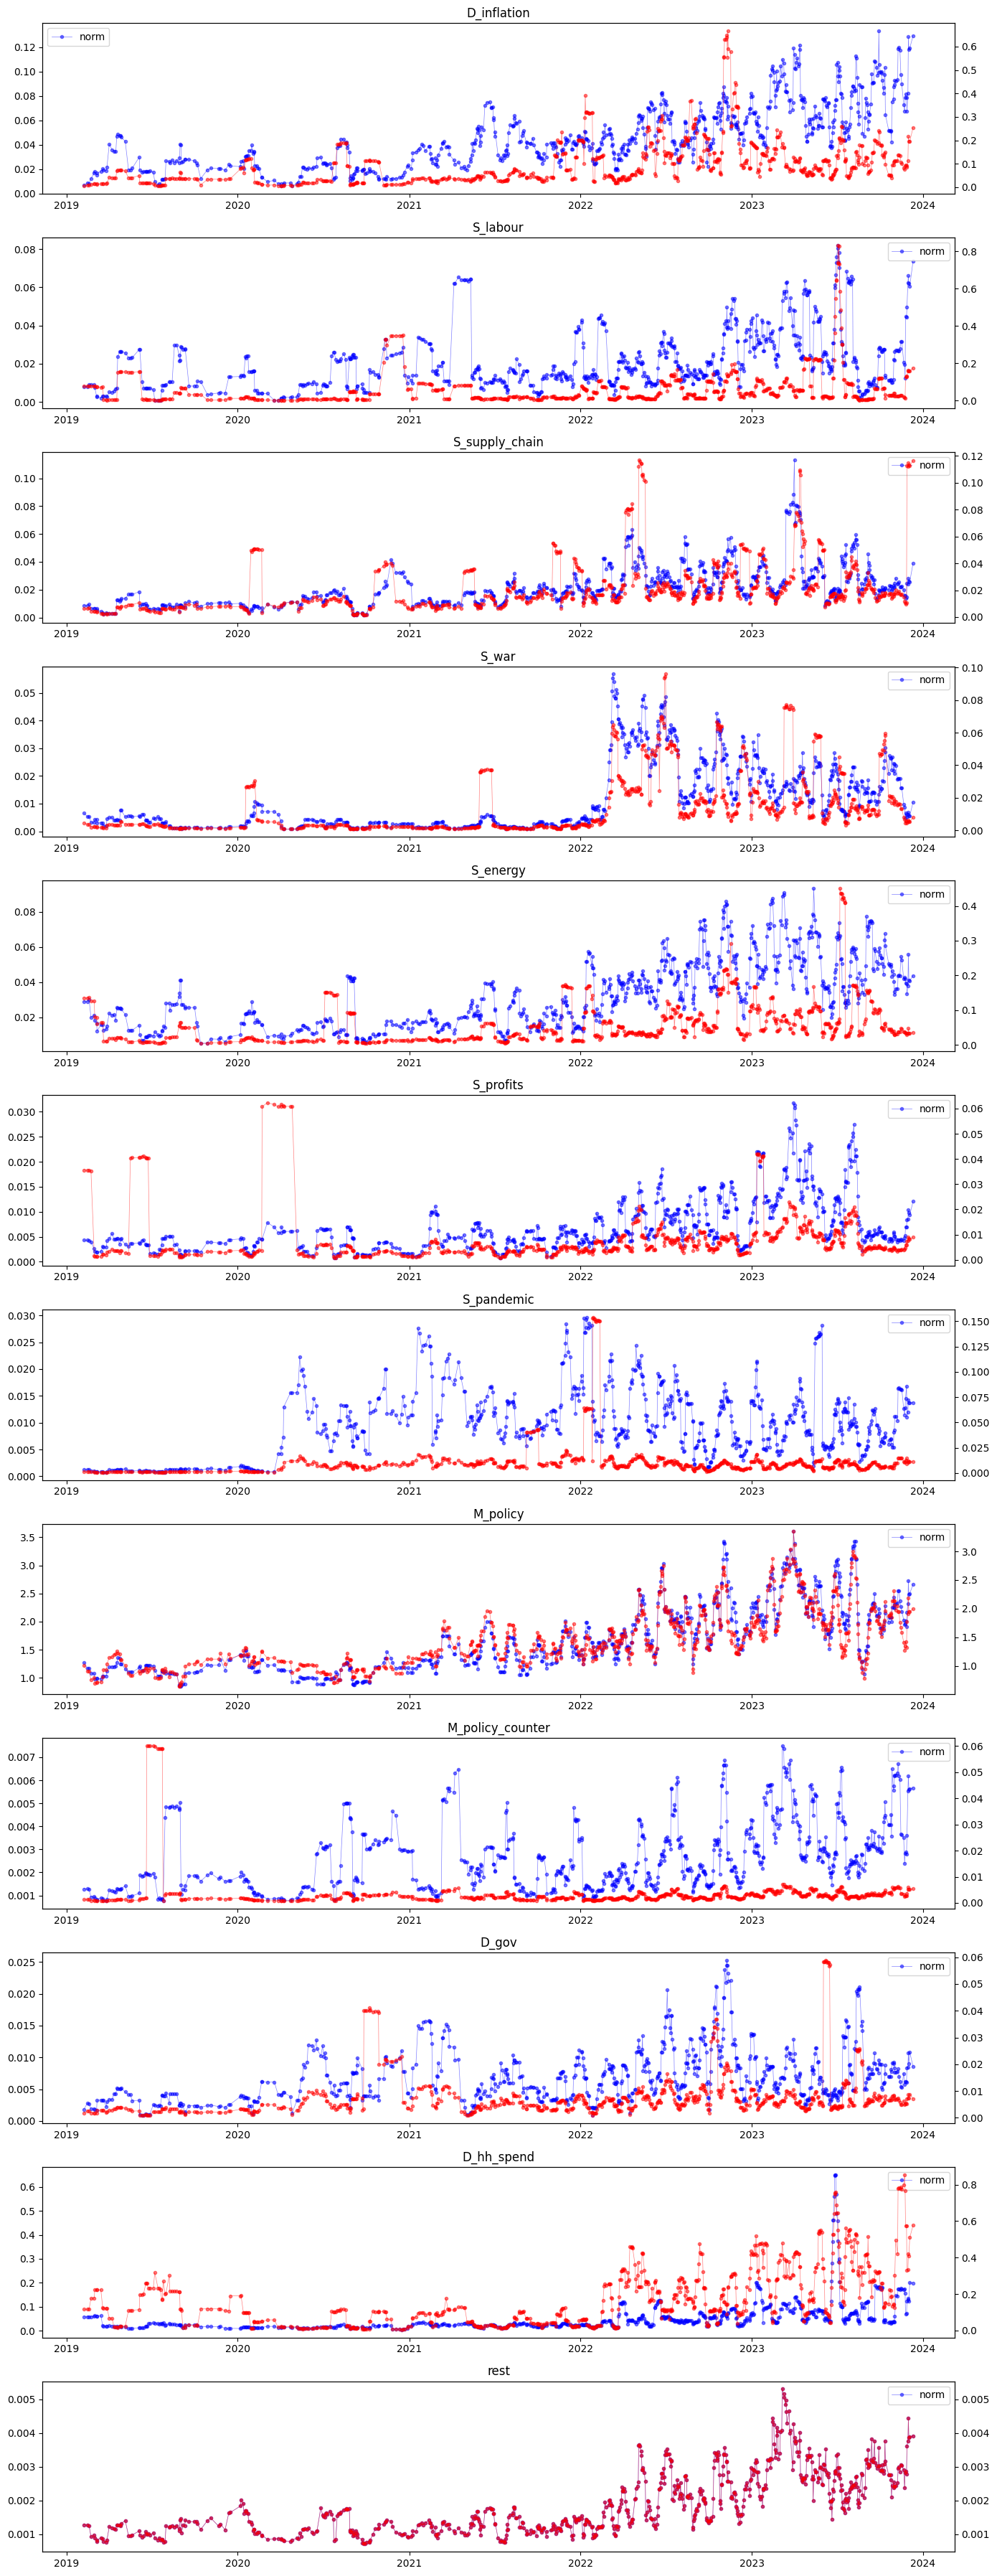

In [29]:
fig, axes = plt.subplots(df.shape[1], 1, figsize=(14, 3*df.shape[1]))
for idx, ax in enumerate(axes.ravel()):
    ax.plot(df_g.iloc[:, idx], lw=.5, marker='.', color='blue', alpha=.5)
    ax.twinx().plot(df_g_cv.iloc[:, idx], lw=.5, marker='.', color='red', alpha=.5)
    ax.legend(['norm'])
    # ax.twinx().legend(['cv'])
    ax.set_title(df_g.columns[idx])
plt.tight_layout()

In [30]:
df.index.name = 'date'
df['id'] = lst_ids

save_pd_df(df, "lda_topics2.feather")

In [31]:
df_cv.index.name = 'date'
df_cv['id'] = lst_ids

save_pd_df(df_cv, "lda_cv_topics2.feather")

In [32]:
save_pkl(out_plda_cv, 'plda_cv_v03.pkl', f_path=MODELS_DIR)